<a href="https://colab.research.google.com/github/Karthik-Venkatesh/100DaysOfMLCode/blob/master/Butterfly_Classifier/Butterfly_Lenet_v1.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Setup


In [0]:
# !tf_upgrade_v2 \
#   --intree my_project/ \
#   --outtree my_project_v2/ \
#   --reportfile report.txt

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  import tensorflow.compat.v2 as tf
except Exception:
  import tensorflow as tf

tf.enable_v2_behavior()

print(tf.__version__)

1.15.0


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Loading Data

In [0]:
import os
import cv2
import glob
import numpy as np
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt
import pathlib
import shutil

In [0]:
if(os.path.isdir("dataset")):
  shutil.rmtree("dataset", ignore_errors=False, onerror=None)
if(os.path.isdir("dev_dataset")):
  shutil.rmtree("dev_dataset", ignore_errors=False, onerror=None)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Uncompress the feature images and labels csv
def uncompress_features_labels(dir,name):
    if(os.path.isdir(name)):
        print('Data extracted')
    else:
        with ZipFile(dir) as zipf:
            zipf.extractall(name)

In [0]:
root_path = '/content/drive/My Drive/Datasets/Sample_Butterflies.zip'  #change dir to your project folder

In [0]:
uncompress_features_labels(root_path,'dataset')

In [0]:
for item in ['Common Mime', 'Common Banded Peacock', 'Common Rose']:
  if(os.path.isdir( f'/content/dev_dataset/{item}')):
    shutil.rmtree( f'/content/dev_dataset/{item}', ignore_errors=False, onerror=None) 
  shutil.copytree(f'/content/dataset/{item}', f'/content/dev_dataset/{item}')

In [0]:
path = 'dev_dataset'
data_dir = pathlib.Path(path)
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

237

# Utills

In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['Common Mime', 'Common Banded Peacock', 'Common Rose'],
      dtype='<U21')

In [0]:
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCS = 10

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

# Image Augumentation

REF: https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

In [0]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

In [0]:
def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

In [0]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random_uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

In [0]:
def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

# Load using tf.data

REF: https://www.tensorflow.org/tutorials/load_data/images

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))

In [0]:
for f in list_ds.take(5):
  print(f.numpy())

b'dev_dataset/Common Banded Peacock/44. 500_f_143486541_hryuvpjmzhwqdvrkh3dk5mqjnxy3jztr.jpg'
b'dev_dataset/Common Banded Peacock/29. e_8ix0t3koekswmkcfjou1vp_owg36kzfe3mc3ckzovexyb_vmadxfshtgovtjvbupr-fv6uobgrxqrr9lw=s580.jpg'
b'dev_dataset/Common Rose/68. common-rose-pachliopta-aristolochiae-4.jpg'
b'dev_dataset/Common Mime/95. common%20mime_butterfly-m.jpg'
b'dev_dataset/Common Rose/20. csm_pachliopta_aristolochiae_2unten_b_02_61a31461a0.jpg'


In [0]:
train_size = int(0.7 * image_count)
val_size = int(0.15 * image_count)
test_size = image_count - train_size - val_size

SUFFLE_BUFFER_SIZE = int(test_size/2)
STEPS_PER_EPOCH = np.ceil(train_size/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(val_size/BATCH_SIZE)

full_list_dataset = list_ds.shuffle(buffer_size=SUFFLE_BUFFER_SIZE)
train_list_dataset = full_list_dataset.take(train_size)
test_list_dataset = full_list_dataset.skip(train_size)
val_list_dataset = test_list_dataset.take(val_size)
test_list_dataset = test_list_dataset.skip(val_size)

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES 

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
def process_path_flip(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = flip(img)
  return img, label

In [0]:
def process_path_color(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = color(img)
  return img, label

In [0]:
def process_path_rotate(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = rotate(img)
  return img, label

In [0]:
def process_path_zoom(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = zoom(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_normal_ds = train_list_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_flipped_ds = train_list_dataset.map(process_path_flip, num_parallel_calls=AUTOTUNE)
labeled_color_ds = train_list_dataset.map(process_path_color, num_parallel_calls=AUTOTUNE)
# labeled_rotate_ds = train_list_dataset.map(process_path_rotate, num_parallel_calls=AUTOTUNE)
# labeled_zoomed_ds = train_list_dataset.map(process_path_zoom, num_parallel_calls=AUTOTUNE)

train_dataset = (labeled_normal_ds.concatenate(labeled_flipped_ds)).concatenate(labeled_color_ds)
val_dataset = val_list_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

# Number of data in datasets

In [0]:
# count = 0
# for i, batch in labeled_normal_ds.enumerate():
#   count = count + 1
# print('labeled_normal_ds: ', count)

# count = 0
# for i, batch in labeled_flipped_ds.enumerate():
#   count = count + 1
# print('labeled_flipped_ds: ', count)

# count = 0
# for i, batch in labeled_color_ds.enumerate():
#   count = count + 1
# print('labeled_color_ds: ', count)

# count = 0
# for i, batch in train_dataset.enumerate():
#   count = count + 1
# print('train_dataset: ', count)

# count = 0
# for i, batch in val_dataset.enumerate():
#   count = count + 1
# print('val_dataset: ', count)

# count = 0
# for i, batch in test_dataset.enumerate():
#   count = count + 1
# print('test_dataset: ', count)

# Prepare for training

In [0]:
def prepare_data_for_network(ds, cache=True, shuffle_buffer_size=SUFFLE_BUFFER_SIZE):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

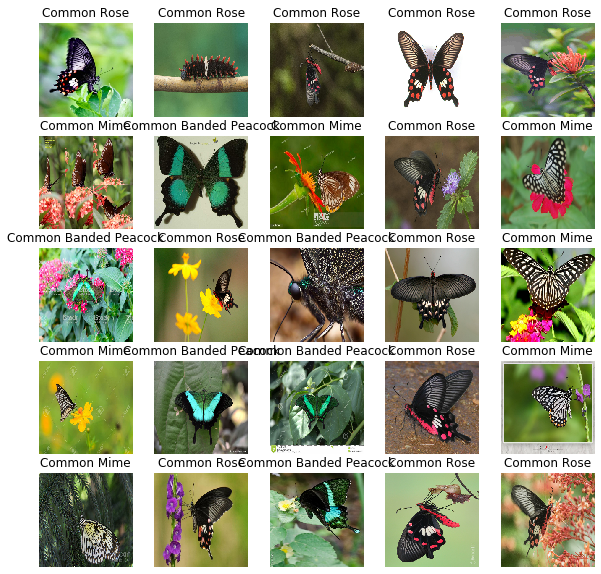

In [0]:
train_ds = prepare_data_for_network(train_dataset)

train_image_batch, train_label_batch = next(iter(train_ds))

show_batch(train_image_batch.numpy(), train_label_batch.numpy())

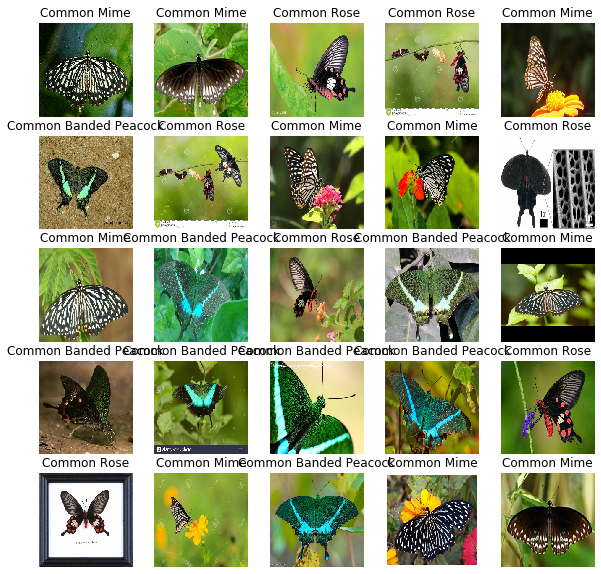

In [0]:
val_ds = prepare_data_for_network(val_dataset)

val_image_batch, val_label_batch = next(iter(val_ds))

show_batch(val_image_batch.numpy(), val_label_batch.numpy())

# CNN Model Training

REF: https://towardsdatascience.com/easy-image-classification-with-tensorflow-2-0-f734fee52d13

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [0]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE, 3), data_format="channels_last"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))

In [0]:
# https://stackoverflow.com/a/58402308/5019015

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit_generator(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCS,
    validation_data=val_ds,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
6/6 [==============================] - 11s 2s/step - loss: 3.8615 - accuracy: 0.3646 - val_loss: 1.1297 - val_accuracy: 0.3438
Epoch 2/10
6/6 [==============================] - 9s 2s/step - loss: 1.1018 - accuracy: 0.4062 - val_loss: 1.0059 - val_accuracy: 0.4844
Epoch 3/10
6/6 [==============================] - 8s 1s/step - loss: 0.9511 - accuracy: 0.5938 - val_loss: 0.7815 - val_accuracy: 0.6406
Epoch 4/10
6/6 [==============================] - 8s 1s/step - loss: 0.7747 - accuracy: 0.6615 - val_loss: 0.5646 - val_accuracy: 0.8125
Epoch 5/10
6/6 [==============================] - 8s 1s/step - loss: 0.6249 - accuracy: 0.7344 - val_loss: 0.4397 - val_accuracy: 0.7812
Epoch 6/10
6/6 [==============================] - 8s 1s/step - loss: 0.4578 - accuracy: 0.8281 - val_loss: 0.3398 - val_accuracy: 0.7812
Epoch 7/10
6/6 [==============================] - 8s 1s/step - loss: 0.3474 - accur

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

# Training and Validation graps

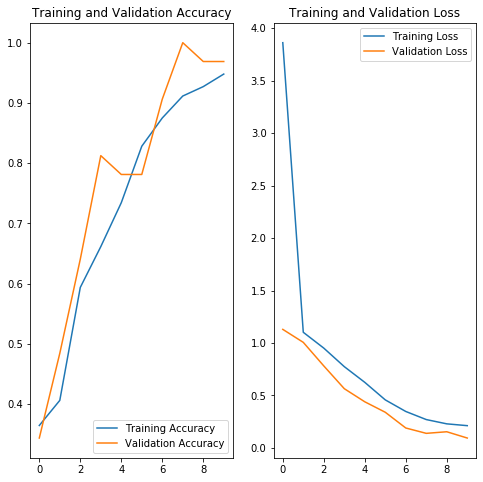

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predictions

Prediction Code Ref: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5


Ref: https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

In [0]:
def load_image(img_path, show = False):
    img_tensor, label = process_path(img_path) # Image With(height, width, channels)

    if show:
        plt.imshow(img_tensor.numpy()) 
        plt.title(CLASS_NAMES[label.numpy()==1][0].title())
        plt.axis('off')
        plt.show()

    img_tensor = np.expand_dims(img_tensor, axis=0) # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    
    return img_tensor

Image path:  tf.Tensor(b'dev_dataset/Common Rose/14. 26209456-beautiful-common-rose-butterfly-with-nice-pink-spots-on-its-wings-pachliopta-aristolochiae-goniopelt.jpg', shape=(), dtype=string)


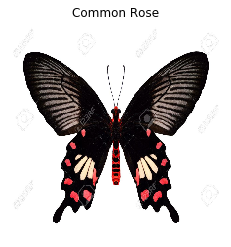

Predictions:  [4.413554e-06 4.516471e-09 9.999956e-01]


In [0]:
image_path = next(iter(test_list_dataset))
print('Image path: ', image_path)
a = load_image(image_path, True)
pred = model.predict(a)
pred = pred[0]
print("Predictions: ", pred)

Ref: http://benalexkeen.com/bar-charts-in-matplotlib/

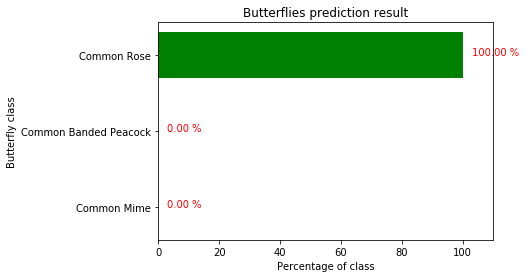

In [0]:
x = CLASS_NAMES
x_pos = [i for i, _ in enumerate(x)]
y_pos = [(per * 100) for per in pred]
plt.barh(x_pos, y_pos, height=0.6, color='green')
plt.ylabel("Butterfly class")
plt.xlabel("Percentage of class")
plt.title("Butterflies prediction result")

for i, v in enumerate(y_pos):
  val = str("{0:.2f}".format(v)) + ' %'
  plt.text(v + 3, i , val, color='red')

plt.yticks(x_pos, x)
plt.xlim([0,110])
plt.show()

# Removing Data

In [0]:
# shutil.rmtree('/content/dataset')
# shutil.rmtree('/content/dev_dataset')